In [1]:
from dotenv import load_dotenv
import os
from google.cloud import bigquery
from pyoso import Client

import numpy as np
import pandas as pd
import warnings

from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
warnings.filterwarnings('ignore')

OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
GCP_PROJECT = 'opensource-observer'
gcp_client = bigquery.Client(project=GCP_PROJECT)

stringify = lambda arr: "'" + "','".join(arr) + "'"

In [2]:
MOST_RECENT_MEASUREMENT_PERIOD = 5

GITHUB_START_DATE = "2020-01-01"
GITHUB_END_DATE   = "2025-06-30"

ONCHAIN_START_DATE = "2025-01-01"
ONCHAIN_END_DATE   = "2025-06-30"

METRIC_START_DATE = "2025-01-01"
METRIC_END_DATE   = "2025-06-01"

RETROFUNDING_REPO_URL = "https://raw.githubusercontent.com/ethereum-optimism/Retro-Funding/refs/heads/main/results/S7"

REFRESH = False

# Queries

## Projects, Rewards, Labels

In [3]:
df_devtool_projects = client.to_pandas("""
   SELECT DISTINCT
     p.project_id AS oso_id,
     p.project_name AS atlas_id,
     p.display_name AS project_name
   FROM projects_v1 AS p
   JOIN projects_by_collection_v1 AS pbc ON p.project_id = pbc.project_id
   JOIN collections_v1 AS c ON pbc.collection_id = c.collection_id
   WHERE c.display_name = 'Retro Funding S7: Developer Tooling'
""")

df_devtool_projects

,oso_id,atlas_id,project_name
0,XbRj/1I9gRExomQ5ClJhhNT42+/C/4NFTIukle+d1G4=,0xb65d1a1f56c8bacffb8e8d7bfac237d459927bfb8924...,Usecase Generator
1,cgPK0M6LzR2cu6RZvz9f60fBsxjCV+ekE7jnvRRtEu4=,0x2866fcc8ea2ad6cc691b8367023c08ba84a34a14685b...,go-ethereum-hdwallet
2,Iz1PaREiXObxPIwbCs72rVgsi/WdlKg4KYrmOfbRs2s=,0x79e8bf2d699790b563aa57fd34da1722bea3191ab5ff...,Etherspot
3,OhSYsbVtaKOxdKm1wJ5WpNfFwiQtMhvVqx11g04Dj6s=,0xa3d07f453f70d844196d89d79848aa2e70a0bd8b38bf...,Ethers.js
4,astvh27IJsLywzvRvATs9iyfMYNt5s9A+WHTfy7smUU=,0xd6622026215d1489594ab9bb76b1e652eae1fd42d180...,Jolt Finance
...,...,...,...
236,iDSZ8iz4xInsAO3aYqBnYUez/tK6LiZdejrZtWxvJSg=,0x40483b3554ae17882db98d1cfd3aae6b10ba82507362...,Superfuse
237,1MvSmaSGrb163SWKc3GOGOVPaulh39cM9SVPdACdDr4=,0x17fb589e599fe05e532b90c121eccc55b1249301e783...,The Ethernaut
238,T5JyiUTt5UnCt95/6Xyjn04da6UU9epzDAizTapPUUU=,0x07222a857f4522026d91faec337e3cb8cf6ec5f7afb8...,Impersonator.xyz
239,wpZkDSZkSrAf85BQoNpzQpmnDcWdnN/5GFtHUPsa0aM=,0xc2d8139cd61ddc75689610ee0cca0fe37ba8bec3270b...,hardhat-gas-reporter


In [4]:
def get_round_results(m_id, category):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/outputs/{category}__results.json"
    result = pd.read_json(url)
    result = result[['op_atlas_id', 'op_reward']]
    result.columns = ['atlas_id', 'op_reward']
    result['category'] = category
    result['measurement_period'] = m_id
    return result

def get_all_round_results(category):
    dfs = []
    for m_id in range(1, MOST_RECENT_MEASUREMENT_PERIOD + 1):
        dfs.append(get_round_results(m_id, category))
    return pd.concat(dfs, axis=0, ignore_index=True)

df_devtool_rewards = get_all_round_results("devtooling").groupby('atlas_id', as_index=False)['op_reward'].sum()
df_devtool_rewards['is_funded'] = df_devtool_rewards['op_reward'] > 0
df_devtool_rewards

,atlas_id,op_reward,is_funded
0,0x0008577196fa6ec286440b418e2f6305fc10e62ce759...,35545.50,True
1,0x07222a857f4522026d91faec337e3cb8cf6ec5f7afb8...,1418.48,True
2,0x076a2b1418a515ff8c5bb11beed5630cc6fe7f65fd8d...,0.00,False
3,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,3822.80,True
4,0x09b95c7697625da4915338750c5f78446817a3634cb3...,9630.26,True
...,...,...,...
240,0xfb3ac4e5f7665c6560e461c1b77ed896d355635947a6...,0.00,False
241,0xfbc74fb5d15b7b2554277371a41ee6ff1bf392377bce...,4235.73,True
242,0xfbecd6308658b3d40a5249d4b249d10537165f57ea52...,0.00,False
243,0xfc54b4a9c537be25238cba3f05100b733aeee83a3eb3...,19145.02,True


In [5]:
def get_devtool_labels(m_id):
    url = f"{RETROFUNDING_REPO_URL}/M{m_id}/data/devtooling__utility_labels.csv"
    df_devtool_labels = pd.read_csv(url)
    df_devtool_labels.columns = ['atlas_id', 'project_name', 'category_label']
    return df_devtool_labels

df_devtool_labels = get_devtool_labels(MOST_RECENT_MEASUREMENT_PERIOD)
df_devtool_labels

,atlas_id,project_name,category_label
0,0x120cdd8e43ae1efbafdf02eda876e1952c05a52870c8...,Passport XYZ | Gitcoin Passport,Application-Specific & Niche Tools
1,0x93decae913f62c0a86519d0b0798e4a10c46c541bfc1...,LlamaPay,Application-Specific & Niche Tools
2,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance,Application-Specific & Niche Tools
3,0x8967594d2978692a35fea137ba640bb42f11cad907ca...,Hats Protocol,Application-Specific & Niche Tools
4,0xcc9301a401320c626839db9c4415f28a6e1f2fb3abdf...,DexKit,Application-Specific & Niche Tools
...,...,...,...
237,0xd6622026215d1489594ab9bb76b1e652eae1fd42d180...,Jolt Finance,Application-Specific & Niche Tools
238,0xeef42373d10554d65aba9e6deb8333a4eddebba829e0...,ERCx: Token Test Library,Deployment & Lifecycle Management
239,0xf152ccbfb3aa63c2ddcc070dc6d4462368eb25b69c3c...,Derive Exchange SDK and Vault Executors,Application-Specific & Niche Tools
240,0xf9c5d092fac6ad924253d685cc7ba21d4e519813e673...,NFTScan,Application-Specific & Niche Tools


## Repos & Developer Metrics

In [6]:
df_devtool_repos = client.to_pandas(f"""
SELECT DISTINCT
  abp.project_name AS atlas_id,
  g.artifact_id,
  g.artifact_url
FROM int_artifacts__github AS g
JOIN artifacts_by_project_v1 AS abp
  ON g.artifact_source_id = abp.artifact_source_id
WHERE abp.project_id IN ({stringify(df_devtool_projects['oso_id'])})
""")

df_devtool_repos

,atlas_id,artifact_id,artifact_url
0,0x8af71ece7f50d6962b589b19854ceac72b81e5f5b301...,JijgzOXAol8LXzL3MRIRJbmWKTiBcXRCtp3/JEUGv14=,https://github.com/runtimeverification/evm-sem...
1,0x3ec2d572a608cf939eaf7886402320b3b2229610c13b...,62fsI0xWscLRJUDW/VUQ+B63JARS7NJqSFenlNyXDIY=,https://github.com/praneshasp/vscode-solidity-...
2,0x935315db8c17993464cfb28337442ad60c6cd4343051...,Xlu7vwFHBgr7xiFiJiySy0DBN6J9WHsGQasheapHQoY=,https://github.com/trashnfts/dumpster-divers
3,0x9b014e8a2e062401d976745d9c8aafbf36bce7931586...,sEI+pwksG9xf/vhbulQfFuaUa+ag0Dyio2xQg9kflcY=,https://github.com/blobscan/blobscan-indexer.rs
4,0x120cdd8e43ae1efbafdf02eda876e1952c05a52870c8...,o8xbzQPbo6aMdFyd15HQMMnW4Jy8vwyZhCQq4uTT4GU=,https://github.com/passportxyz/id-staking-v2
...,...,...,...
673,0x7348ae42266ff626319e8ea5398343b847603b3cc710...,RQAfB8hZMmEB2X4rO1aWIHQYxad9sca7iHTSO71qvBc=,https://github.com/runtimeverification/_audits...
674,0xaa4cf223915387f8e0cd66640f86f4f770d0c1edfc43...,nKbMvDP+Og8jzxMRF1DgPMMltg0W71ujzu2JO2eICHI=,https://github.com/farcaster-attestation/farca...
675,0x740297a85de756f69945e2cfd9d439598cdb06a70e40...,/B7zZVCkUNhJuAog4UWeA3Qj5o0ZWGLPnRSerivg4rM=,https://github.com/the-old-castle-defense/drs
676,0xc6052138bbdae5976fa2866f46b0537182d4126c4bb9...,qR13bMr81MOnxSJ1/ouSvIRGOVju8SrtgdZq4/dUNtA=,https://github.com/nftlabs/nftlabs-protocols


In [7]:
if REFRESH:
    df_devtool_metrics = client.to_pandas(f"""
    WITH metrics AS (
      SELECT metric_id, metric_name
      FROM metrics_v0
      WHERE metric_name IN (
        'GITHUB_full_time_developers_monthly',
        'GITHUB_part_time_developers_monthly',
        'GITHUB_active_developers_monthly'
      )
    ),
    devtool_repos AS (
      SELECT artifact_id
      FROM UNNEST(ARRAY[{stringify(df_devtool_repos['artifact_id'].unique())}]) AS t(artifact_id)
    )
    
    SELECT
      tm.sample_date,
      tm.artifact_id,
      m.metric_name AS metric,
      SUM(tm.amount) AS amount
    FROM timeseries_metrics_by_artifact_v0 AS tm
    JOIN metrics AS m ON tm.metric_id = m.metric_id
    JOIN devtool_repos AS r ON tm.artifact_id = r.artifact_id
    WHERE tm.sample_date BETWEEN DATE('{GITHUB_START_DATE}') AND DATE('{GITHUB_END_DATE}')
    GROUP BY 1,2,3
    """)
    df_devtool_metrics.to_parquet('data/20250714_s7_devtool_metrics.parquet')
else:
    df_devtool_metrics = pd.read_parquet('data/20250714_s7_devtool_metrics.parquet')
    
df_devtool_metrics

,sample_date,artifact_id,metric,amount
0,2025-04-01,ootS4LJQ94kS8pAfYXLCldraflytVHDosJ1+ccVW48g=,GITHUB_part_time_developers_monthly,1
1,2022-08-01,7gfUMG9YyhLNuspTO/Ngiew/POy59TSssoKKZ+Hmsd4=,GITHUB_active_developers_monthly,4
2,2024-09-01,gBvck53YFeJ2Y1E13o77Y97fu8S88jHwKg4GWj/LtzI=,GITHUB_part_time_developers_monthly,1
3,2024-01-01,LfWiAWM9zHcL6sspKZpGd2fwFdgpYSQoHH73pY7AXZs=,GITHUB_part_time_developers_monthly,1
4,2024-06-01,4eJNGaWQzYqCqNR5PfDfa8MabU2GhoIkWJWmRO62bBk=,GITHUB_active_developers_monthly,1
...,...,...,...,...
14665,2025-04-01,GB690/7oarGnNEQcqnxIgIcBcjpZZV7D+fwAG42gr60=,GITHUB_active_developers_monthly,2
14666,2024-01-01,w/EbnYHHCQ7tgHIRnVukIU0X3oktBmz2I0qXtynDOpg=,GITHUB_active_developers_monthly,4
14667,2024-07-01,/Mk3y4o7pUi5esk3VoLvZ5X++QZxfb74v4eq2fxM3BY=,GITHUB_active_developers_monthly,5
14668,2025-02-01,3oGBurKqwQ7yJ7qwrqjjDKQ/j38Jf4ZNsTMHOpBjuXA=,GITHUB_active_developers_monthly,2


## Downstream Gas & Devs

In [8]:
df_dependency_graph = client.to_pandas(f"""
SELECT DISTINCT
  cd.dependency_artifact_id,
  p.project_id,
  p.project_name
FROM int_code_dependencies AS cd
JOIN int_superchain_s7_devtooling_onchain_builder_nodes AS onchain_builders
  ON cd.dependent_artifact_id = onchain_builders.repo_artifact_id
JOIN projects_v1 AS p ON onchain_builders.project_id = p.project_id
WHERE cd.dependency_artifact_id IN ({stringify(df_devtool_repos['artifact_id'])})
""")

df_dependency_graph

,dependency_artifact_id,project_id,project_name
0,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,sPO1pl4Y+FnbbMxaMnMwDEGVxZFJzf6bGUNniLdJcaU=,zora
1,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,CEgSH0sLKChprauip73TEAlNieWnpX+HRIV5re4xPIc=,gelato
2,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,k51QTl16C/ZunIrGFIMHwuqxXmJO0qugcFKfmR0AGh0=,moonwell-fi
3,zhNff0/ix8NGTW+ia5gB9fQwj69uG0Y1Xwj22U53RSc=,2D5YRxufnDHKS+HeGRxq/fquJWda1owfPsxOQFcXAys=,summer-fi
4,Zv9i5shYSOh9Bw+maVk0uF2+fwjKE3y5wRh8Se+nTeg=,Pq7ymk/RUVaf+iAZVzBk0Ws7wIb0LvKfvj7YqQyo+Mk=,size-credit
...,...,...,...
2961,Kiizi127ss6Z79antU3mSbG+x+dHOLxvc6SDay3NTHA=,v+EPc4pOnT53GyWYLFzP9nZ0CjoQ1cntyeqd+9wOnWg=,mintswapfinance
2962,lycu1tyiKItr0LtKjzHm3dmwMjsxt4KfYpTzh9u60SQ=,5TUMW7BunipNIyPtlxBlNbrCHFMH4sRoMuly6BLtj44=,sonex
2963,Kiizi127ss6Z79antU3mSbG+x+dHOLxvc6SDay3NTHA=,R/brPbiaD8+ZOgc2k4NVBYT3oWYh50xHrkVT0zKFP94=,jojoexchange
2964,bDZO/13jhIR7SC2bmHxOYqPph+37iVQL+j+Y9y1I1WA=,ngBRwzug+4yZnN2uE1wfoLeIsHQy9coImbvxkwYxfmk=,flayerlabs


In [9]:
df_downstream_devs = client.to_pandas(f"""
WITH onchain_builders AS (
  SELECT DISTINCT project_id
  FROM int_superchain_s7_devtooling_onchain_builder_nodes
  WHERE
    sample_date = DATE('{METRIC_END_DATE}')
    AND project_id IN ({stringify(df_dependency_graph['project_id'].unique())})
),
metrics AS (
  SELECT metric_id, metric_name
  FROM metrics_v0
  WHERE metric_name IN (
    'GITHUB_full_time_developers_monthly',
    'GITHUB_part_time_developers_monthly',
    'GITHUB_active_developers_monthly'
  )
)
SELECT
  tm.sample_date,
  tm.project_id,
  m.metric_name AS metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_project_v0 AS tm
JOIN onchain_builders ON tm.project_id = onchain_builders.project_id
JOIN metrics AS m ON tm.metric_id = m.metric_id
WHERE sample_date BETWEEN DATE('{GITHUB_START_DATE}') AND DATE('{GITHUB_END_DATE}')
GROUP BY 1,2,3
""")

df_downstream_devs

,sample_date,project_id,metric,amount
0,2021-04-01,dOKZpVgYpZmAJZ+f0bYZWqKGpkz25Klgk4ZjY/fdyAc=,GITHUB_active_developers_monthly,11
1,2021-02-01,cYKtZm5LcO+lBzh/EHUjfUxeT0RV+1rhpsH/ZXkfwms=,GITHUB_full_time_developers_monthly,3
2,2021-12-01,QTGRjfPgumLZqvmjh/nP1wE3ZWzKnGhCY/E72h1wusw=,GITHUB_active_developers_monthly,5
3,2021-12-01,hE1BjGS8I9OXjnYATSkRnNJlsItBXO+CKXU6UPKJlRQ=,GITHUB_part_time_developers_monthly,5
4,2021-12-01,4iXU/Dlz1CBdUGyuiUP6IiMJtBR+GKUn1tkbSSLOGQQ=,GITHUB_part_time_developers_monthly,1
...,...,...,...,...
12301,2020-03-01,pWEQHj4IsxU8lx2EDLJpphYaGAvw/yRps3vgTbVCXjQ=,GITHUB_active_developers_monthly,1
12302,2020-03-01,L1FGc2AIMWcbDulPkpgzndWnljElZEAxxr+jPOdn0WQ=,GITHUB_active_developers_monthly,8
12303,2020-03-01,L1FGc2AIMWcbDulPkpgzndWnljElZEAxxr+jPOdn0WQ=,GITHUB_part_time_developers_monthly,4
12304,2020-09-01,IC4gXIZe/sWGrV5sOyeoSlqkS7t4BZd40afZT+2Q7bA=,GITHUB_active_developers_monthly,3


In [10]:
if REFRESH:
    df_deduped_devs = client.to_pandas(f"""
    WITH dev_repos AS (
      SELECT artifact_id
      FROM UNNEST(ARRAY[{stringify(df_devtool_repos['artifact_id'].unique())}]) AS t(artifact_id)
    ),
    onchain_repos AS (
      SELECT artifact_id
      FROM artifacts_by_project_v1
      WHERE
        project_id IN ({stringify(df_dependency_graph['project_id'].unique())})
        AND artifact_source = 'GITHUB'
    ),
    all_repos AS (
      SELECT artifact_id FROM dev_repos
      UNION
      SELECT artifact_id FROM onchain_repos
    )
    
    SELECT
      DATE_TRUNC('MONTH', bucket_day) AS month,
      APPROX_DISTINCT(e.from_artifact_id) AS unique_devs
    FROM int_events_daily__github AS e
    JOIN all_repos ON e.to_artifact_id = all_repos.artifact_id
    WHERE
      e.bucket_day BETWEEN DATE('2023-01-01') AND DATE('{GITHUB_END_DATE}')
      AND e.event_type = 'COMMIT_CODE'
    GROUP BY 1
    ORDER BY 1
    """)
    df_deduped_devs.to_parquet('data/20250714_deduped_devs.parquet')
else:
    df_deduped_devs = pd.read_parquet('data/20250714_deduped_devs.parquet')
    
df_deduped_devs.tail()

,month,unique_devs
25,2025-02-01,1054
26,2025-03-01,1044
27,2025-04-01,1115
28,2025-05-01,914
29,2025-06-01,814


In [11]:
if REFRESH:
    df_downstream_gas = gcp_client.query(f"""
    WITH projects AS (
      SELECT
        project_id,
        artifact_name AS address,
        artifact_source AS chain
      FROM `oso_production.artifacts_by_project_v1`
      WHERE project_id IN ({stringify(df_downstream_devs['project_id'])})
    ),
    txns AS (
      SELECT
        dt,
        to_address,
        CASE
          WHEN chain = 'op' THEN 'OPTIMISM'
          WHEN chain = 'fraxtal' THEN 'FRAX'
          ELSE UPPER(chain)
        END AS chain,
        (receipt_gas_used / 1e18 * receipt_effective_gas_price) AS gas_fee
      FROM `optimism_superchain_raw_onchain_data.transactions`
      WHERE dt BETWEEN '{ONCHAIN_START_DATE}' AND '{ONCHAIN_END_DATE}'
    )    
    SELECT
      txns.dt,
      projects.project_id,
      txns.chain,
      SUM(gas_fee) AS gas_fees
    FROM txns
    JOIN projects
      ON
        txns.to_address = projects.address
        AND txns.chain = projects.chain
    GROUP BY 1,2,3
    """).to_dataframe()
    df_downstream_gas.to_parquet('data/20250714_s7_downstream_gasfees.parquet')
else:
    df_downstream_gas = pd.read_parquet('data/20250714_s7_downstream_gasfees.parquet')

df_downstream_gas

,dt,project_id,chain,gas_fees
0,2025-01-05,Zy6ZHnI5FaGA6G9Pm0+DxqvFg3pcni2pcNqd6VPbsG8=,INK,6.461534e-05
1,2025-01-04,ec9PEUQwIfXCq7fpDHA2JwxwoxTgF+8o62D67ixlTbM=,OPTIMISM,6.144296e-05
2,2025-01-12,Jpscljo0tkzVDYKwVNnTSuR+AFUyy4EHg4AWd+Mdnd4=,ORDERLY,6.561671e-04
3,2025-01-05,2D5YRxufnDHKS+HeGRxq/fquJWda1owfPsxOQFcXAys=,BASE,5.655825e-04
4,2025-01-12,p3mu9598KidLIbo8g8ZW2jgJjlv1JxF5pAooOzmYIiw=,MODE,7.022315e-06
...,...,...,...,...
84699,2025-06-30,IC4gXIZe/sWGrV5sOyeoSlqkS7t4BZd40afZT+2Q7bA=,BASE,1.513897e-03
84700,2025-06-30,PjPqPTput/vvThUxx6bMhInMKHuCV3t1s+K4YiHjIRg=,OPTIMISM,1.314413e-02
84701,2025-06-30,cKV5yAmptkrG53RQ+vd6UrIQLLlm7hILNJMpDPYmQV8=,BASE,6.083644e-05
84702,2025-06-30,0wTetcgdAs7+boj3ROTnd7BiHXTxK1oGU3haIFFyc4s=,BASE,3.396960e-02


In [12]:
if REFRESH:
    df_superchain_gas = gcp_client.query(f"""
    WITH txns AS (
      SELECT
        dt,
        CASE
          WHEN chain = 'op' THEN 'OPTIMISM'
          WHEN chain = 'fraxtal' THEN 'FRAX'
          ELSE UPPER(chain)
        END AS chain,
        (receipt_gas_used / 1e18 * receipt_effective_gas_price) AS gas_fee
      FROM `optimism_superchain_raw_onchain_data.transactions`
      WHERE dt BETWEEN '{ONCHAIN_START_DATE}' AND '{ONCHAIN_END_DATE}'
    )    
    SELECT
      dt,
      chain,
      SUM(gas_fee) AS gas_fees
    FROM txns
    GROUP BY dt, chain
    ORDER BY dt
    """).to_dataframe()
    df_superchain_gas.to_parquet('data/20250714_superchain_gasfees.parquet')
else:
    df_superchain_gas = pd.read_parquet('data/20250714_superchain_gasfees.parquet')

df_superchain_gas

,dt,chain,gas_fees
0,2025-01-01,FRAX,0.026828
1,2025-01-01,BASE,95.398025
2,2025-01-01,CYBER,0.008171
3,2025-01-01,XTERIO,0.000000
4,2025-01-01,SWELL,0.018647
...,...,...,...
4737,2025-06-30,REDSTONE,0.001356
4738,2025-06-30,ZORA,0.004524
4739,2025-06-30,AUTOMATA,0.001250
4740,2025-06-30,BASE,44.015665


In [13]:
df_downstream_txn_counts = client.to_pandas(f"""
WITH contracts AS (
  SELECT artifact_id
  FROM artifacts_by_project_v1
  WHERE project_id IN ({stringify(df_downstream_devs['project_id'])})
)
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{ONCHAIN_START_DATE}' AS date,
  'downstream' AS measure
FROM int_events__blockchain AS e
JOIN contracts AS c ON e.to_artifact_id = c.artifact_id
WHERE DATE(e.time) = DATE('{ONCHAIN_START_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{ONCHAIN_END_DATE}' AS date,
  'downstream' AS measure
FROM int_events__blockchain AS e
JOIN contracts AS c ON e.to_artifact_id = c.artifact_id
WHERE DATE(e.time) = DATE('{ONCHAIN_END_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{ONCHAIN_START_DATE}' AS date,
  'total' AS measure
FROM int_events__blockchain AS e
WHERE DATE(e.time) = DATE('{ONCHAIN_START_DATE}')
UNION
SELECT
  APPROX_DISTINCT(transaction_hash) AS txn_count,
  '{ONCHAIN_END_DATE}' AS date,
  'total' AS measure
FROM int_events__blockchain AS e
WHERE DATE(e.time) = DATE('{ONCHAIN_END_DATE}')
""")

df_downstream_txn_counts = df_downstream_txn_counts.pivot(index='date', columns='measure', values='txn_count')
df_downstream_txn_counts

measure,downstream,total
date,,
2025-01-01,5926943,11955917
2025-06-30,7805738,17652380


In [14]:
df_downstream_txn_counts['downstream'] / df_downstream_txn_counts['total']

date
2025-01-01    0.495733
2025-06-30    0.442192
dtype: Float64

## Center of Gravity

In [15]:
df_center_of_gravity = client.to_pandas(f"""
SELECT
  cd.dependency_artifact_id AS artifact_id,
  COUNT(DISTINCT CASE WHEN onchain_builders.project_id IS NOT NULL THEN cd.dependent_artifact_id END) AS superchain_dependent_repos,
  COUNT(DISTINCT cd.dependent_artifact_id) AS all_dependent_repos
FROM int_code_dependencies AS cd
LEFT JOIN int_superchain_s7_devtooling_onchain_builder_nodes AS onchain_builders
  ON cd.dependent_artifact_id = onchain_builders.repo_artifact_id
WHERE cd.dependency_artifact_id IN ({stringify(df_devtool_repos['artifact_id'])})
GROUP BY 1
""")

df_center_of_gravity

,artifact_id,superchain_dependent_repos,all_dependent_repos
0,Kiizi127ss6Z79antU3mSbG+x+dHOLxvc6SDay3NTHA=,879,7556
1,0LiyWLP8iexBQeWRper+37LxVdJb0rzHsiGRkpCDEOo=,164,1212
2,GaxOFf2If6rbAo6AC6PR3BB0/8sFa9wbwYzonMyhnRk=,1,81
3,VRhymGAMSGrpyB+awXkmsf+XNfoMDxWbVzOuUpAb29k=,1293,12077
4,Y3ENgjn4737Lf91HITfpCd8FK7J78rvhRVgAKgVOv7U=,0,3
...,...,...,...
113,rKBoujXkdm8jlaoCemmJDIMVH41t6EzXU9r75dk+dDs=,0,3
114,3VhTjSJ8vCL8ddp3GgLF/fxP+QzRAZTqs37R2fqy/yM=,0,72
115,FYA19PVN0i9rO8w/sFY5KMXXGN+IULbAEqPij/E2kXw=,24,146
116,9iXKyV2Y8moyw3doVu6AIjDVuUZbkQFGoRBkcdWN+KE=,2,3


In [16]:
df_dev_cohorts = client.to_pandas(f"""
WITH project_flags AS (
  SELECT
    project_id,
    max(case when collection_name IN ('optimism', 'base-crypto-ecosystems') then 1 else 0 end) AS is_optimism,
    max(case when collection_name NOT IN ('optimism', 'base-crypto-ecosystems') then 1 else 0 end) AS is_other
  FROM projects_by_collection_v1
  WHERE 
    collection_name IN (    
      'optimism',
      'base-crypto-ecosystems',
      'arbitrum-crypto-ecosystems',
      'arb-onchain',
      'polygon-crypto-ecosystems',
      'zksync-crypto-ecosystems',
      'protocol-labs-network'
    )
    AND project_id NOT IN (
      SELECT project_id
      FROM projects_by_collection_v1
      WHERE collection_name IN ('protocol-guild', 'ethereum-github')
    )
  GROUP BY project_id
),
project_cohorts AS (
  SELECT
    project_id,
    case
      when is_optimism = 1 and is_other = 0 then 'Only Optimism'
      when is_optimism = 0 and is_other = 1 then 'Only Other Ecosystems'
      when is_optimism = 1 and is_other = 1 then 'Optimism and Other Ecosystems'
    end AS cohort
  FROM project_flags
)
SELECT
  tm.sample_date,
  pc.cohort,
  m.metric_name AS metric,
  SUM(tm.amount) AS amount
FROM timeseries_metrics_by_project_v0 tm
JOIN metrics_v0 m USING (metric_id)
JOIN project_cohorts pc USING (project_id)
WHERE tm.sample_date
      BETWEEN DATE('{GITHUB_START_DATE}') AND DATE('{GITHUB_END_DATE}')
  AND m.metric_name IN (
    'GITHUB_full_time_developers_monthly',
    'GITHUB_active_developers_monthly'
  )
GROUP BY 1,2,3
ORDER BY 1,3,2
""")

df_dev_cohorts.tail(10)

,sample_date,cohort,metric,amount
386,2025-05-01,Optimism and Other Ecosystems,GITHUB_active_developers_monthly,856
387,2025-05-01,Only Optimism,GITHUB_full_time_developers_monthly,112
388,2025-05-01,Only Other Ecosystems,GITHUB_full_time_developers_monthly,52
389,2025-05-01,Optimism and Other Ecosystems,GITHUB_full_time_developers_monthly,90
390,2025-06-01,Only Optimism,GITHUB_active_developers_monthly,748
391,2025-06-01,Only Other Ecosystems,GITHUB_active_developers_monthly,670
392,2025-06-01,Optimism and Other Ecosystems,GITHUB_active_developers_monthly,763
393,2025-06-01,Only Optimism,GITHUB_full_time_developers_monthly,75
394,2025-06-01,Only Other Ecosystems,GITHUB_full_time_developers_monthly,56
395,2025-06-01,Optimism and Other Ecosystems,GITHUB_full_time_developers_monthly,74


In [17]:
df_dev_cohorts.tail(10)

,sample_date,cohort,metric,amount
386,2025-05-01,Optimism and Other Ecosystems,GITHUB_active_developers_monthly,856
387,2025-05-01,Only Optimism,GITHUB_full_time_developers_monthly,112
388,2025-05-01,Only Other Ecosystems,GITHUB_full_time_developers_monthly,52
389,2025-05-01,Optimism and Other Ecosystems,GITHUB_full_time_developers_monthly,90
390,2025-06-01,Only Optimism,GITHUB_active_developers_monthly,748
391,2025-06-01,Only Other Ecosystems,GITHUB_active_developers_monthly,670
392,2025-06-01,Optimism and Other Ecosystems,GITHUB_active_developers_monthly,763
393,2025-06-01,Only Optimism,GITHUB_full_time_developers_monthly,75
394,2025-06-01,Only Other Ecosystems,GITHUB_full_time_developers_monthly,56
395,2025-06-01,Optimism and Other Ecosystems,GITHUB_full_time_developers_monthly,74


# Transformations

## Project Derived Metrics

In [18]:
df_devtool_metrics_by_project = (
    df_devtool_metrics
    .merge(df_devtool_repos, on='artifact_id')
    .groupby(['sample_date', 'atlas_id', 'metric'], as_index=False)['amount']
    .sum()
)
df_devtool_metrics_by_project['sample_date'] = pd.to_datetime(df_devtool_metrics_by_project['sample_date'])
df_devtool_metrics_by_project['atlas_id'].nunique()

237

In [19]:
df_center_of_gravity_by_project = (
    df_center_of_gravity
    .merge(df_devtool_repos, on='artifact_id')
    .sort_values(by=['superchain_dependent_repos', 'all_dependent_repos'], ascending=False)
    .drop_duplicates(subset='atlas_id', keep='first')
)
df_center_of_gravity_by_project = df_center_of_gravity_by_project[['atlas_id', 'superchain_dependent_repos', 'all_dependent_repos']]
df_center_of_gravity_by_project['superchain_ratio'] = (
    df_center_of_gravity_by_project['superchain_dependent_repos'] 
    / df_center_of_gravity_by_project['all_dependent_repos']
)
df_center_of_gravity_by_project['is_eligible_package'] = df_center_of_gravity_by_project['superchain_dependent_repos'] >= 3
df_center_of_gravity_by_project

,atlas_id,superchain_dependent_repos,all_dependent_repos,superchain_ratio,is_eligible_package
17,0xa3d07f453f70d844196d89d79848aa2e70a0bd8b38bf...,1876,18724,0.100192,True
3,0x62d9a8a3b602c688610abfbe3965e04ca0d19c5c506f...,1293,12077,0.107063,True
87,0x4c9626843c4e3f3c96d80b0ec6b1d10b7682fc9b6d67...,1035,10260,0.100877,True
12,0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d...,930,8186,0.113609,True
0,0x939241afa4c4b9e1dda6b8250baa8f04fa8b0debce73...,879,7556,0.116331,True
...,...,...,...,...,...
59,0xa7d78d566bfa319479ec048c94c3d8c1f4d628a9344b...,0,1,0.0,False
72,0x1e7a1f9763d25b6844567a7133b1005ef6ed785642a7...,0,1,0.0,False
84,0x3a942492f564e13e4a3fc11e9a8b5dcd8bf0213f9dd8...,0,1,0.0,False
90,0x7cbd306b4b54416b83eb723a79b88d09554e245b1d7b...,0,1,0.0,False


In [20]:
def enrich_project_devstats():

    FT_DEVS = 'GITHUB_full_time_developers_monthly'
    PT_DEVS = 'GITHUB_part_time_developers_monthly'
    ALL_DEVS = 'GITHUB_active_developers_monthly'
    FT_COST = 7800
    PT_COST = FT_COST / 4

    def summarize(df, metric, aggfunc, name, positive_only=False):
        subset = df[df.metric.eq(metric)]
        if positive_only:
            subset = subset[subset.amount.gt(0)]
        return subset.groupby('atlas_id').amount.agg(aggfunc).rename(name)

    def maintainer(ft_devs, min_devs, avg_devs):
        if min_devs == 0:
            return "0: Inactive"
        elif ft_devs >= 2 or min_devs >= 4:
            return '3: 2+ full-time devs'
        elif avg_devs <= 1:
            return '1: <1 full-time devs'
        else:
            return '2: 1-2 full-time devs'

    df = df_devtool_metrics_by_project.copy()
    df.sample_date = pd.to_datetime(df.sample_date)
    dff = df[df.sample_date.between(METRIC_START_DATE, METRIC_END_DATE)]
    date_max = dff['sample_date'].max(0)
    
    max_full = summarize(dff, FT_DEVS, 'max', 'max_full_time_devs')
    min_active = summarize(dff, ALL_DEVS, 'min', 'min_active_devs', positive_only=True)
    avg_active = summarize(dff, ALL_DEVS, 'mean', 'avg_active_devs')
    lifetime_ft_dev_months =summarize(df, FT_DEVS, 'sum', 'lifetime_ft_dev_months')
    lifetime_pt_dev_months =summarize(df, PT_DEVS, 'sum', 'lifetime_pt_dev_months')
    
    first_active = df[df.metric.eq(ALL_DEVS)].groupby('atlas_id').sample_date.min()
    years_old = ((date_max - first_active).dt.days / 365).rename('years_old')
    
    metadata = pd.concat([max_full, min_active, avg_active, lifetime_ft_dev_months, lifetime_pt_dev_months, years_old], axis=1).fillna(0)
    metadata['older_than_3_years'] = metadata['years_old'] >= 3
    
    metadata['maintainer_profile'] = metadata.apply(
        lambda x: maintainer(x['max_full_time_devs'], x['min_active_devs'], x['avg_active_devs'])
        , axis=1)

    metadata['min_cost_to_rebuild'] = metadata['lifetime_ft_dev_months'] * FT_COST + metadata['lifetime_pt_dev_months'] * PT_COST
    return metadata

df_devtools_enriched = enrich_project_devstats()    
df_devtools_enriched

,max_full_time_devs,min_active_devs,avg_active_devs,lifetime_ft_dev_months,lifetime_pt_dev_months,years_old,older_than_3_years,maintainer_profile,min_cost_to_rebuild
atlas_id,,,,,,,,,
0x0008577196fa6ec286440b418e2f6305fc10e62ce759625d826be272ee6b45a3,1,1,1.0,19,2,1.668493,False,1: <1 full-time devs,152100.0
0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be0f3ad513db6f13c755dd,1,1,3.6,1,44,2.835616,False,2: 1-2 full-time devs,93600.0
0x14eab8b10f729239d63df6c0cb85f666c3eb1f2dd440ebd003c1821f186a49da,1,1,1.333333,15,65,4.331507,True,2: 1-2 full-time devs,243750.0
0x1e7a1f9763d25b6844567a7133b1005ef6ed785642a75229acf1b9b25202a5f3,1,1,1.666667,9,11,0.917808,False,2: 1-2 full-time devs,91650.0
0x2247247c751707d897f5c0eab670426d9c1c26d84e96ac226004afbf0080cba4,1,1,2.0,3,50,1.750685,False,2: 1-2 full-time devs,120900.0
...,...,...,...,...,...,...,...,...,...
0xcb0434aaf86a5dca68f96edefc22bf04a16bbfaa48b0a4a40c844f1afb8d7b1e,0,0,0.0,0,1,1.000000,False,0: Inactive,1950.0
0xd7a8e115b2b3772d7d5656d7798e349dcdedf2463302c78528c9e9686ab4efe3,0,0,0.0,0,1,0.747945,False,0: Inactive,1950.0
0xe20f59eb1c8f9cb72e07b8d0f067bac997614fd6db06d8c031c5c9235f760dcc,0,0,0.0,0,2,1.416438,False,0: Inactive,3900.0


In [21]:
df_devtool_labels

,atlas_id,project_name,category_label
0,0x120cdd8e43ae1efbafdf02eda876e1952c05a52870c8...,Passport XYZ | Gitcoin Passport,Application-Specific & Niche Tools
1,0x93decae913f62c0a86519d0b0798e4a10c46c541bfc1...,LlamaPay,Application-Specific & Niche Tools
2,0x08df6e20a3cfabbaf8f34d4f4d048fe7da40447c24be...,Velodrome Finance,Application-Specific & Niche Tools
3,0x8967594d2978692a35fea137ba640bb42f11cad907ca...,Hats Protocol,Application-Specific & Niche Tools
4,0xcc9301a401320c626839db9c4415f28a6e1f2fb3abdf...,DexKit,Application-Specific & Niche Tools
...,...,...,...
237,0xd6622026215d1489594ab9bb76b1e652eae1fd42d180...,Jolt Finance,Application-Specific & Niche Tools
238,0xeef42373d10554d65aba9e6deb8333a4eddebba829e0...,ERCx: Token Test Library,Deployment & Lifecycle Management
239,0xf152ccbfb3aa63c2ddcc070dc6d4462368eb25b69c3c...,Derive Exchange SDK and Vault Executors,Application-Specific & Niche Tools
240,0xf9c5d092fac6ad924253d685cc7ba21d4e519813e673...,NFTScan,Application-Specific & Niche Tools


In [22]:
df_project_metrics_pivoted = (
    df_devtool_projects.set_index('atlas_id')[['project_name']]
    .join(df_devtool_labels.set_index('atlas_id')[['category_label']])
    .join(df_devtool_rewards.set_index('atlas_id'))
    .join(df_devtools_enriched)
    .join(df_center_of_gravity_by_project.set_index('atlas_id'))
    .sort_values(by='op_reward', ascending=False)
)
df_project_metrics_pivoted['is_eligible_package'].fillna(False, inplace=True)
df_project_metrics_pivoted['weighted_cost_to_rebuild'] = (
    df_project_metrics_pivoted['superchain_ratio'].fillna(0)
    * df_project_metrics_pivoted['min_cost_to_rebuild']
)
df_project_metrics_pivoted

,project_name,category_label,op_reward,is_funded,max_full_time_devs,min_active_devs,avg_active_devs,lifetime_ft_dev_months,lifetime_pt_dev_months,years_old,older_than_3_years,maintainer_profile,min_cost_to_rebuild,superchain_dependent_repos,all_dependent_repos,superchain_ratio,is_eligible_package,weighted_cost_to_rebuild
atlas_id,,,,,,,,,,,,,,,,,,
0x939241afa4c4b9e1dda6b8250baa8f04fa8b0debce738cfd324c0b18f9926d25,OpenZeppelin Contracts,Core Protocol Interfaces,356000.01,True,2,11,13.0,53,417,5.419178,True,3: 2+ full-time devs,1226550.0,879,7556,0.116331,True,142686.26919
0xa3d07f453f70d844196d89d79848aa2e70a0bd8b38bf0f493cba1547bb3bca5e,Ethers.js,Core Protocol Interfaces,356000.01,True,0,1,1.0,0,25,2.331507,False,1: <1 full-time devs,48750.0,1876,18724,0.100192,True,4884.372997
0x6bd057da522918a4675396313ae33a2f2788a1ceeb3bd7ae228015e3eb317a7d,Viem: TypeScript Interface for Ethereum,Core Protocol Interfaces,356000.01,True,1,1,1.5,37,34,2.254795,False,2: 1-2 full-time devs,354900.0,511,4146,0.123251,True,43741.895803
0xcc8d03e014e121d10602eeff729b755d5dc6a317df0d6302c8a9d3b5424aaba8,Solidity,Language & Compilation Tools,356000.01,True,1,4,6.833333,36,490,5.419178,True,3: 2+ full-time devs,1236300.0,930,8186,0.113609,True,140454.31224
0x670a2982f6d7786b58a8399bcabc23246365b21e533a97945e055791fc235e64,Hardhat,Development Frameworks,356000.01,True,0,6,8.833333,4,182,2.750685,False,3: 2+ full-time devs,386100.0,862,7008,0.123002,True,47491.181507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0xcc9301a401320c626839db9c4415f28a6e1f2fb3abdf38ada785b57409bdedb6,DexKit,Application-Specific & Niche Tools,0.00,False,1,1,2.0,2,14,2.750685,False,2: 1-2 full-time devs,42900.0,<NA>,<NA>,<NA>,False,0.0
0xe6eb4d61eff4e2dc2d8dba01ac1b84c1683bdb1e8d677a66fa44a72e3f8b1faf,Zabi,Core Protocol Interfaces,0.00,False,0,1,1.166667,10,9,1.416438,False,2: 1-2 full-time devs,95550.0,<NA>,<NA>,<NA>,False,0.0
0x24ff0fb2933e55b169a80d9bd35a00a7011795387717b27445ccdc0f8660d740,OpenOcean,Application-Specific & Niche Tools,0.00,False,0,0,0.0,0,4,3.750685,True,0: Inactive,7800.0,<NA>,<NA>,<NA>,False,0.0


## Descriptive Stats

In [23]:
dollars = lambda x: f"${x:,.0f}"

In [24]:
print("Total OP:", df_project_metrics_pivoted['op_reward'].sum().astype(int))
print("Funded:", len(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]))
print("Applicants:", len(df_project_metrics_pivoted))

Total OP: 6600000
Funded: 97
Applicants: 241


In [25]:
print("Median OP:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].median())
max_op = round(df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['op_reward'].max())
print("Max OP:", max_op)
for x in sorted(df_project_metrics_pivoted[df_project_metrics_pivoted['op_reward'] >= max_op]['project_name'].unique()):
    print(" -", x)

Median OP: 24695.17
Max OP: 356000
 - Ethers.js
 - Hardhat
 - OpenZeppelin Contracts
 - Solidity
 - Viem: TypeScript Interface for Ethereum


In [26]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('is_eligible_package')['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

,count,sum,median
is_eligible_package,,,
False,59,1159932,9878
True,38,5440068,105658


In [27]:
for x in df_project_metrics_pivoted[~df_project_metrics_pivoted['is_eligible_package']]['project_name'].head(5):
    print(" -", x)

 - DefiLlama
 - 🏗️  Scaffold-ETH 2
 - Ape Framework
 - Foundry
 - Titanoboa


In [28]:
df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']][
    ['lifetime_ft_dev_months', 'lifetime_pt_dev_months', 'max_full_time_devs', 'avg_active_devs']
].sum()

lifetime_ft_dev_months    1491.0
lifetime_pt_dev_months    7804.0
max_full_time_devs          60.0
avg_active_devs            249.7
dtype: Float64

In [29]:
print("Min cost to rebuild:", dollars(df_project_metrics_pivoted['min_cost_to_rebuild'].sum()))
print(df_project_metrics_pivoted.groupby('is_funded')['min_cost_to_rebuild'].sum().apply(dollars))
print()
print("Weighted cost to rebuild:", dollars(df_project_metrics_pivoted['weighted_cost_to_rebuild'].sum()))
print(df_project_metrics_pivoted.groupby('is_funded')['weighted_cost_to_rebuild'].sum().apply(dollars))

Min cost to rebuild: $34,594,950
is_funded
False     $7,747,350
True     $26,847,600
Name: min_cost_to_rebuild, dtype: object

Weighted cost to rebuild: $2,035,282
is_funded
False      $118,380
True     $1,916,902
Name: weighted_cost_to_rebuild, dtype: object


In [30]:
print("Median age (years):", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['years_old'].median())
print("Median active devs:", df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['avg_active_devs'].median())

Median age (years): 3.5013698630136987
Median active devs: 1.5


In [31]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('older_than_3_years')['op_reward'].agg(['count', 'sum', 'median'])
)

,count,sum,median
older_than_3_years,,,
False,42,2304587.93,12177.805
True,55,4295412.07,59694.460


In [32]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby('maintainer_profile')['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

,count,sum,median
maintainer_profile,,,
0: Inactive,2,17606,8803
1: <1 full-time devs,36,2114886,29135
2: 1-2 full-time devs,45,2349543,13396
3: 2+ full-time devs,14,2117965,125097


In [33]:
(
    df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]
    .groupby(['older_than_3_years', 'maintainer_profile'])['op_reward']
    .agg(['count', 'sum', 'median'])
    .apply(round)
    .astype(int)
)

count      sum  median
older_than_3_years maintainer_profile                           
False              0: Inactive                2    17606    8803
                   1: <1 full-time devs      17   889711   16620
                   2: 1-2 full-time devs     21  1026836    6575
                   3: 2+ full-time devs       2   370435  185217
True               1: <1 full-time devs      19  1225176   49320
                   2: 1-2 full-time devs     24  1322707   19990
                   3: 2+ full-time devs      12  1747530  125097

## Downstream Stats

In [34]:
print("Devtooling Devs")
(
    df_devtool_metrics_by_project[df_devtool_metrics_by_project['sample_date'].between(METRIC_START_DATE, METRIC_END_DATE)]
    .groupby('metric')['amount']
    .sum() / 6    
).apply(round)

Devtooling Devs


metric
GITHUB_active_developers_monthly       363
GITHUB_full_time_developers_monthly     36
GITHUB_part_time_developers_monthly    327
Name: amount, dtype: int64

In [35]:
print("Onchain Devs")
(
    df_downstream_devs[df_downstream_devs['sample_date'].between(METRIC_START_DATE, METRIC_END_DATE)]
    .groupby('metric')['amount']
    .sum() / 6    
).apply(round)

Onchain Devs


metric
GITHUB_active_developers_monthly       724
GITHUB_full_time_developers_monthly     89
GITHUB_part_time_developers_monthly    636
Name: amount, dtype: int64

In [36]:
df_downstream_devs['project_id'].nunique()

177

In [37]:
print(df_deduped_devs.set_index('month')['unique_devs'].rolling(window=3).mean().loc['2023-04-01'])
df_deduped_devs.set_index('month')['unique_devs'].rolling(window=3).mean().loc['2025-04-01']

726.6666666666666


1071.0

In [38]:
print("Downstream gas (last 6 months):", df_downstream_gas['gas_fees'].sum(), "ETH")
print("Total Superchain gas (last 6 months):", df_superchain_gas['gas_fees'].sum(), "ETH")
print("Share:", round(df_downstream_gas['gas_fees'].sum() / df_superchain_gas['gas_fees'].sum() * 100,2), "%")

Downstream gas (last 6 months): 1567.0771703218936 ETH
Total Superchain gas (last 6 months): 16999.500280963715 ETH
Share: 9.22 %


In [39]:
(
    df_downstream_devs
    .query("metric != 'GITHUB_active_developers_monthly'")
    .groupby(['project_id', 'metric'], as_index=False)['amount']
    .sum()
    .pivot(index='project_id', columns='metric', values='amount')
)

metric,GITHUB_full_time_developers_monthly,GITHUB_part_time_developers_monthly
project_id,,
+Yqnb1vNtZ7qeamha1KsaDhLsAIFFNR4ZVgM4svDOZ4=,48,236
/48A4/LZsBf1ztk3blMoY9kPQjx8knNp/EabsEszQ4Y=,107,754
0bo+FpuyeDxXcG5AQW0QWClfmYYQ2G9yEnOqxofAKys=,83,471
0rInH1b9Mh04BAwmikdFhcH/YDDR7xg7vxtho7SyKsY=,<NA>,116
0wTetcgdAs7+boj3ROTnd7BiHXTxK1oGU3haIFFyc4s=,<NA>,22
...,...,...
yBTsqg28U+BoAz6n48dJzWbCDuQGBnsZ1srW1qhIJ10=,<NA>,3
yZEfzA9tUugnZhQ0Yqx6FvvyEHiEgXVgx6A6tpglPdw=,3,110
ynNcbWgLkOpL7ijgFRe7wPIhS1IWOmm7uNerNWtlA/w=,2,92


In [40]:
df_downstream_replacement_cost = (
    df_dependency_graph
    .rename(columns={'dependency_artifact_id': 'artifact_id', 'project_name': 'builder_name'})
    .merge(df_devtool_repos, on='artifact_id')
    [['atlas_id', 'builder_name']]
    .drop_duplicates()
    .merge(df_project_metrics_pivoted.reset_index()[['atlas_id', 'min_cost_to_rebuild',  'weighted_cost_to_rebuild', 'avg_active_devs']], on='atlas_id')
    .groupby('builder_name')[['min_cost_to_rebuild', 'weighted_cost_to_rebuild', 'avg_active_devs']]
    .sum()
    .sort_values(by='min_cost_to_rebuild', ascending=False)
)
df_downstream_replacement_cost.head(10)

,min_cost_to_rebuild,weighted_cost_to_rebuild,avg_active_devs
builder_name,,,
gelato,8330400.0,1014520.650372,81.666667
curve,7566000.0,853539.670188,71.766667
angle-protocol,7382700.0,827958.912519,76.766667
third-web,7201350.0,863389.301011,70.233333
fraxfinance,7164300.0,761478.346003,70.733333
aave,7090200.0,781886.838744,73.433333
balancer,7012200.0,743315.762426,76.833333
summer-fi,6889350.0,775661.145154,72.9
aragon,6887400.0,967377.42673,68.233333


In [41]:
print(df_downstream_replacement_cost['min_cost_to_rebuild'].sum())
print(df_downstream_replacement_cost['weighted_cost_to_rebuild'].sum())

862327050.0
99469498.84616008


# Visualizations

In [42]:
_fmt = lambda x: f"{x}" if isinstance(x, str) or x < 1000 else f"{x/1000:.0f}K"

_category_summary = (
    df_project_metrics_pivoted
    .groupby('category_label')[['project_name']]
    .count()
    .rename(columns={'project_name': 'applicants'})
    .join(
        df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded'] == True]
        .groupby('category_label')
        .agg(
            num_projects = ('project_name','count'),
            median_op    = ('op_reward',   'median'),        
            total_op     = ('op_reward',   'sum')     
        )
    )
    .fillna(0)
    .sort_values(by='total_op', ascending=False)
)
_category_summary['share'] = (_category_summary['total_op'] / _category_summary['total_op'].sum()).apply(lambda x: f"{x*100:.1f}%")
_category_summary = _category_summary[['applicants', 'num_projects', 'median_op', 'total_op', 'share']].applymap(_fmt).reset_index()
print(_category_summary.to_markdown(index=False, tablefmt='github'))

| category_label                     |   applicants |   num_projects | median_op   | total_op   | share   |
|------------------------------------|--------------|----------------|-------------|------------|---------|
| Core Protocol Interfaces           |           39 |             23 | 60K         | 2384K      | 36.1%   |
| Development Frameworks             |           12 |              7 | 70K         | 688K       | 10.4%   |
| Cryptography & Primitives          |            7 |              6 | 98K         | 574K       | 8.7%    |
| Developer Experience Tools         |           36 |             14 | 12K         | 548K       | 8.3%    |
| Language & Compilation Tools       |            7 |              6 | 42K         | 528K       | 8.0%    |
| Infrastructure & Node Operations   |           16 |              9 | 34K         | 469K       | 7.1%    |
| Testing & Verification Tools       |           16 |             12 | 9K          | 455K       | 6.9%    |
| Data Indexing & Analytics 

Text(0.0, 1.0, 'Distribution of Package "Center of Gravity" Measures')

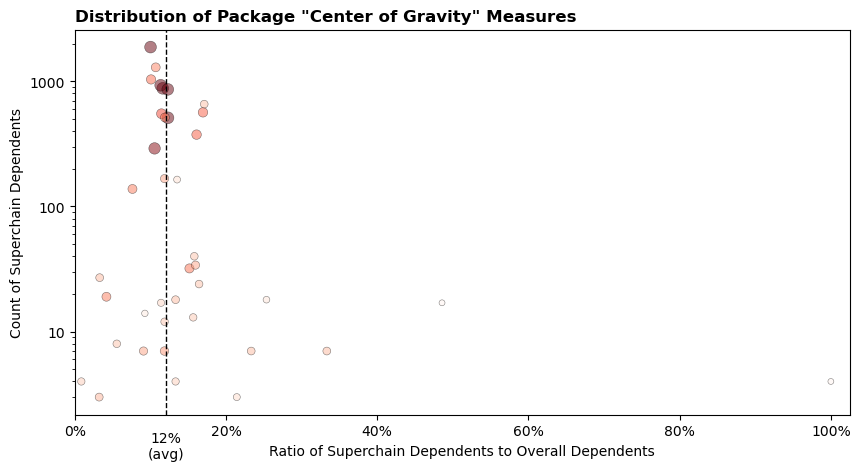

In [43]:
_gravity_cols = ['project_name', 'op_reward', 'superchain_ratio', 'superchain_dependent_repos', 'all_dependent_repos']
_df_gravity = df_project_metrics_pivoted[df_project_metrics_pivoted['is_eligible_package']][_gravity_cols]
_weighted_avg = np.average(_df_gravity['superchain_ratio'], weights=_df_gravity['superchain_dependent_repos'])

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(
    data=_df_gravity,
    x='superchain_ratio',
    y='superchain_dependent_repos',
    size='op_reward',
    norm=LogNorm(), 
    hue='op_reward',
    palette='Reds',
    alpha=0.5,
    edgecolor='black',
    legend=False,
    ax=ax
)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0))
ax.set_xlim(0, 1.025)

ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}'))
ax.axvline(_weighted_avg, color='black', linestyle='--', linewidth=1)

# optional: annotate the line with its value
ax.text(_weighted_avg, ax.get_ylim()[0], f'\n{_weighted_avg:.0%}\n(avg)', rotation=0, va='top', ha='center')
ax.set_ylabel('Count of Superchain Dependents')
ax.set_xlabel('Ratio of Superchain Dependents to Overall Dependents')
ax.set_title('Distribution of Package "Center of Gravity" Measures', loc='left', weight='bold')

In [44]:
print(
    pd.concat([
        _df_gravity.sort_values(by='superchain_dependent_repos').tail(3),
        _df_gravity.sort_values(by='superchain_ratio').tail(3),
        _df_gravity.sort_values(by='superchain_ratio').head(3),   
    ])
    .sort_values(by='superchain_ratio', ascending=False)
    [['project_name', 'superchain_dependent_repos', 'all_dependent_repos', 'superchain_ratio']]
    .to_markdown(index=False, tablefmt='github')
)

| project_name           |   superchain_dependent_repos |   all_dependent_repos |   superchain_ratio |
|------------------------|------------------------------|-----------------------|--------------------|
| viem-tracer            |                            4 |                     4 |         1          |
| Aragon OSx             |                           17 |                    35 |         0.485714   |
| Cannon                 |                            7 |                    21 |         0.333333   |
| noble cryptography     |                         1293 |                 12077 |         0.107063   |
| ethereum-bloom-filters |                         1035 |                 10260 |         0.100877   |
| Ethers.js              |                         1876 |                 18724 |         0.100192   |
| js-libp2p              |                           27 |                   820 |         0.0329268  |
| Revm                   |                            3 |                

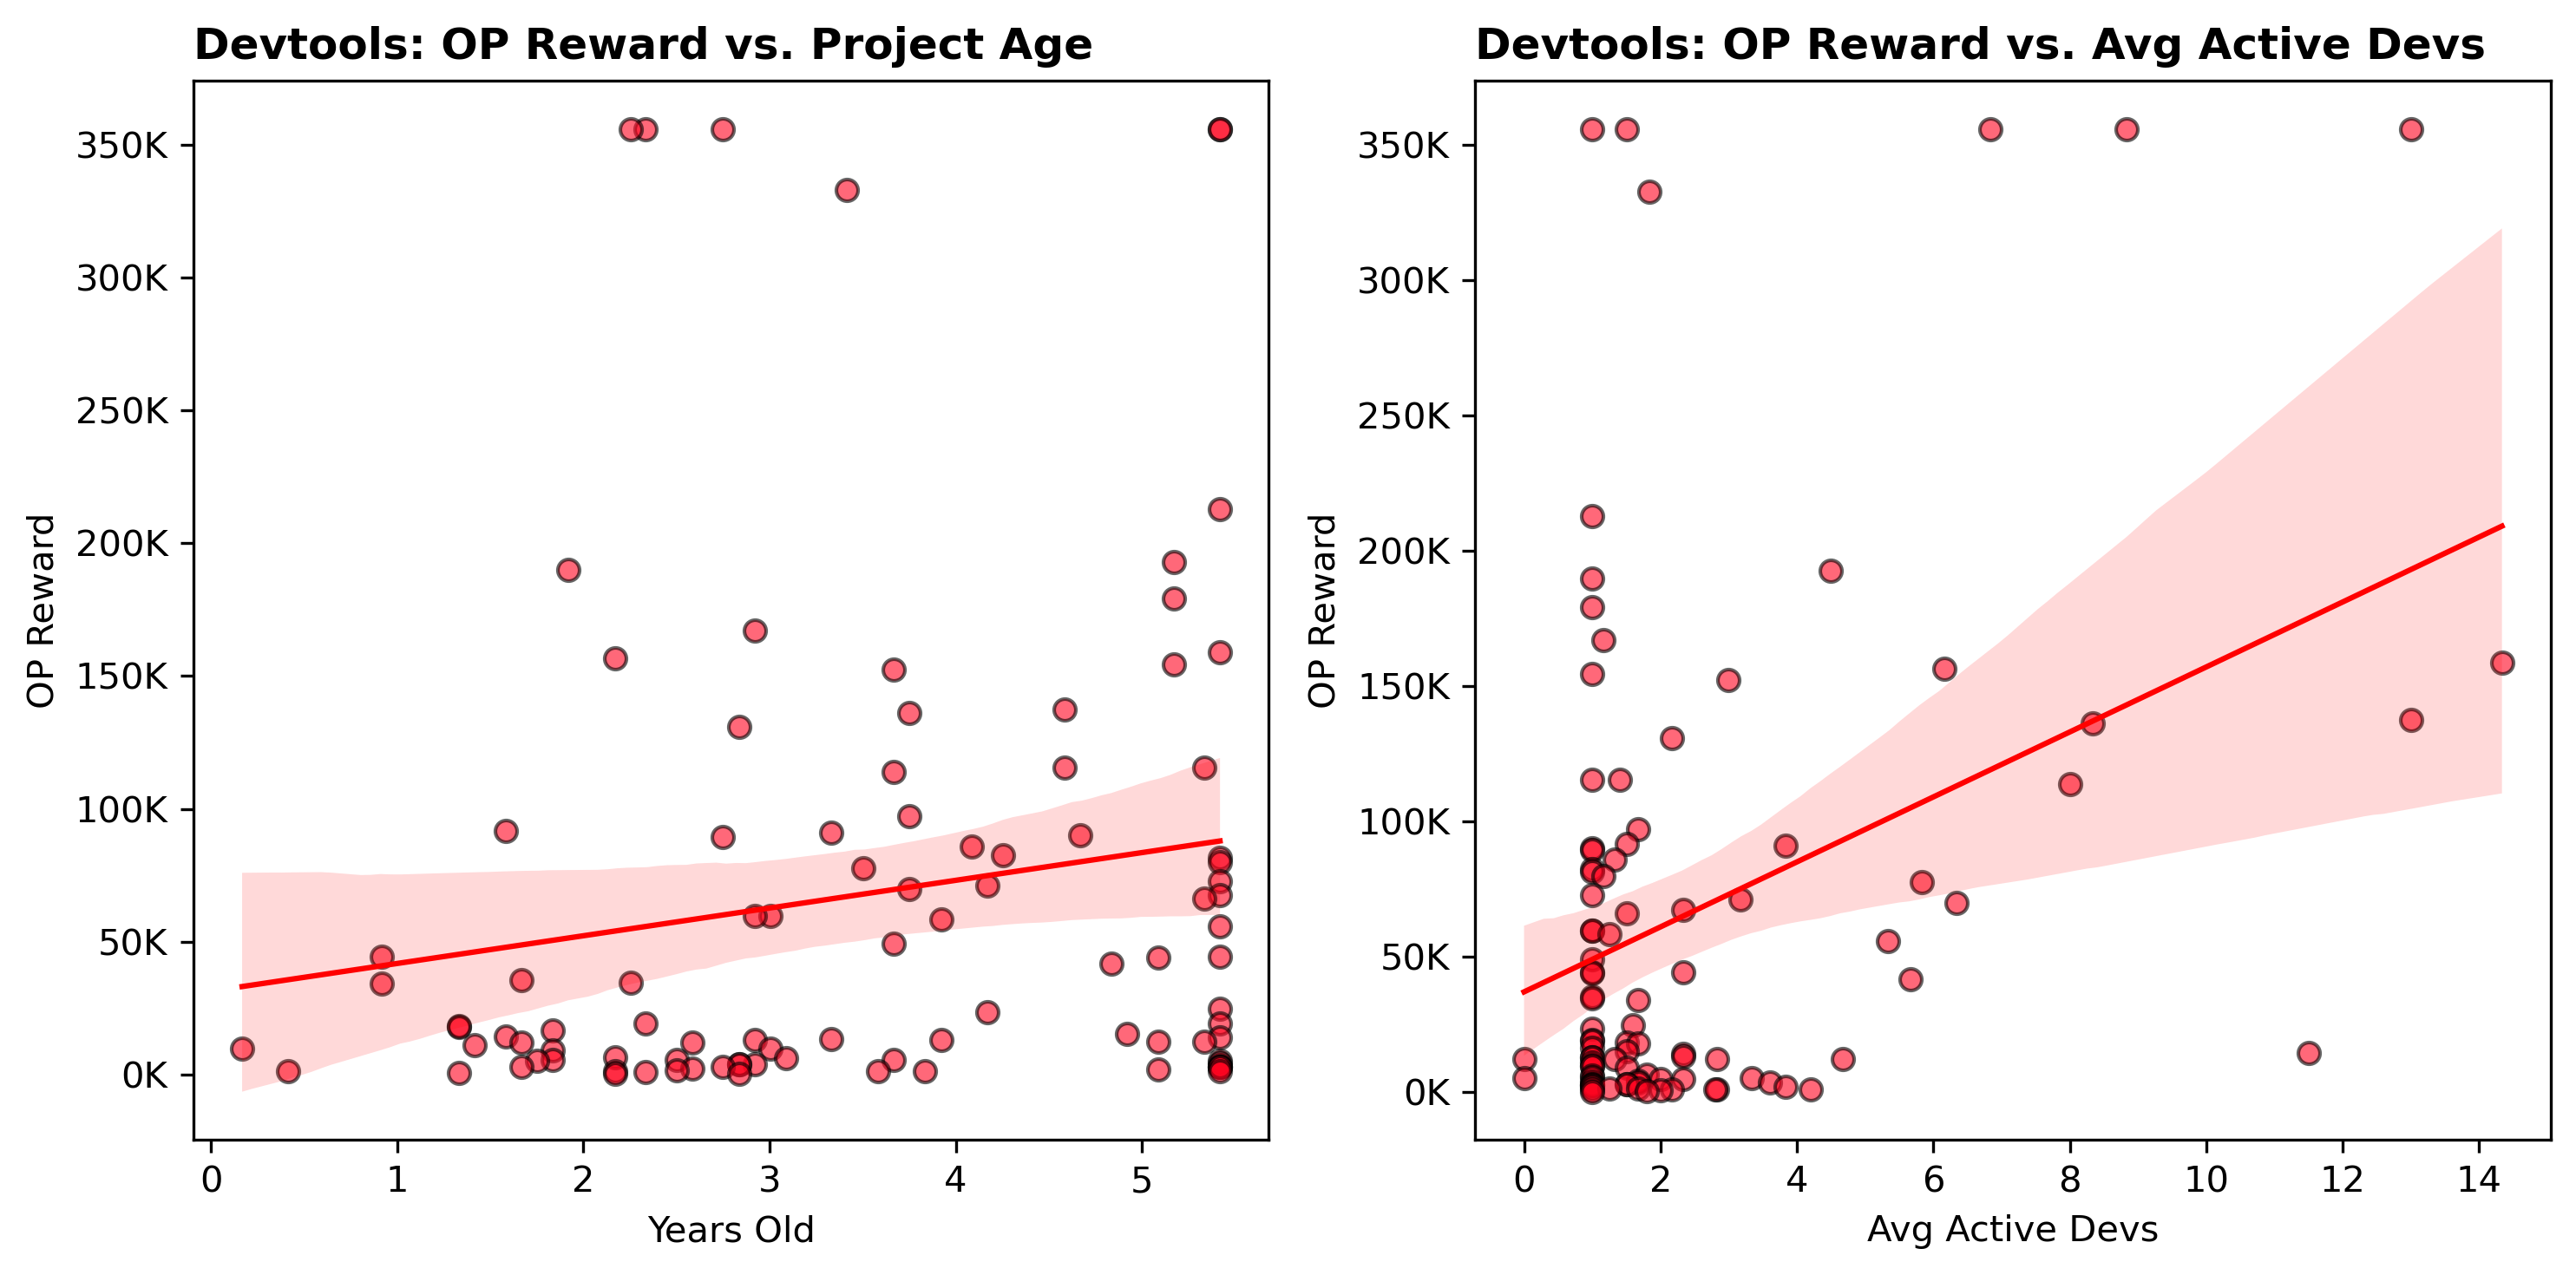

In [45]:
k_formatter = mticker.FuncFormatter(lambda y, _: f"{int(y/1000)}K")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
_df_team = df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]

sns.regplot(
    data=_df_team,
    x='years_old',
    y='op_reward',
    scatter_kws={'alpha': 0.6, 'edgecolor': 'black', 'color': '#ff0420'},
    line_kws={'color': 'red', 'lw': 1.5},
    ax=axes[0]
)
axes[0].set_title('Devtools: OP Reward vs. Project Age', loc='left', weight='bold')
axes[0].set_xlabel('Years Old')
axes[0].set_ylabel('OP Reward')
axes[0].yaxis.set_major_formatter(k_formatter)

# ─── RIGHT PANE: avg active devs vs. OP reward ───────────────────────────
sns.regplot(
    data=_df_team,
    x='avg_active_devs',
    y='op_reward',
    scatter_kws={'alpha': 0.6, 'edgecolor': 'black', 'color': '#ff0420'},
    line_kws={'color': 'red', 'lw': 1.5},
    ax=axes[1]
)
axes[1].set_title('Devtools: OP Reward vs. Avg Active Devs', loc='left', weight='bold')
axes[1].set_xlabel('Avg Active Devs')
axes[1].set_ylabel('OP Reward')
axes[1].yaxis.set_major_formatter(k_formatter)

plt.tight_layout()
plt.show()

In [46]:
(
    df_devtool_metrics_by_project
    .merge(
        df_project_metrics_pivoted[['maintainer_profile']].reset_index(), on='atlas_id'
    )
    .query("metric == 'GITHUB_active_developers_monthly'")
    .pivot_table(
        index='sample_date',
        columns='maintainer_profile',
        values='amount',
        aggfunc='sum'
    )
)

maintainer_profile,0: Inactive,1: <1 full-time devs,2: 1-2 full-time devs,3: 2+ full-time devs
sample_date,,,,
2020-01-01,<NA>,7,13,13
2020-02-01,<NA>,6,16,14
2020-03-01,<NA>,5,13,10
2020-04-01,<NA>,6,18,12
2020-05-01,<NA>,7,18,16
...,...,...,...,...
2025-02-01,<NA>,66,242,151
2025-03-01,<NA>,46,204,152
2025-04-01,<NA>,58,194,145


In [47]:
df_project_metrics_pivoted[df_project_metrics_pivoted['is_funded']]['maintainer_profile'].value_counts()

maintainer_profile
2: 1-2 full-time devs    45
1: <1 full-time devs     36
3: 2+ full-time devs     14
0: Inactive               2
Name: count, dtype: int64

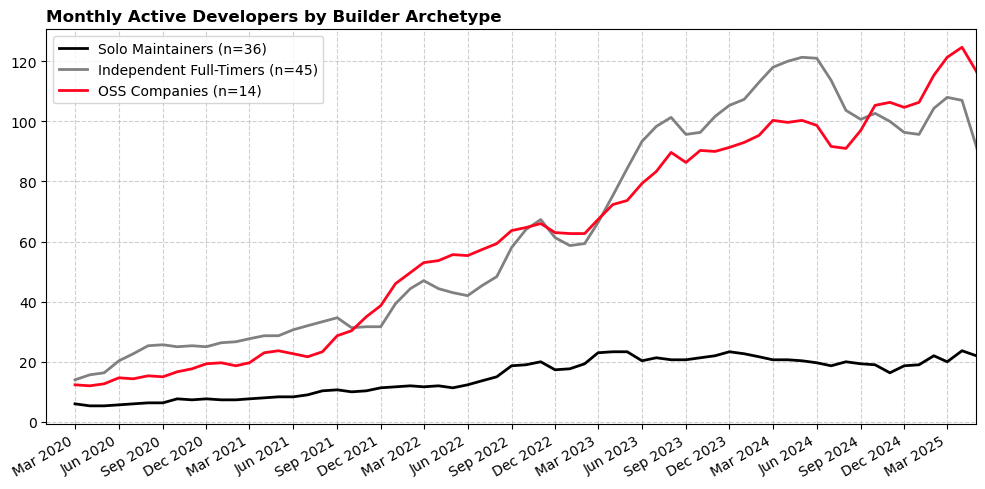

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

_df_dev_profiles = (
    df_devtool_metrics_by_project
    .merge(
        df_project_metrics_pivoted[['maintainer_profile', 'is_funded']].reset_index(), on='atlas_id'
    )
    .query("metric == 'GITHUB_active_developers_monthly'")
    .query("maintainer_profile != '0: Inactive'")
    .query("is_funded == True")
    .pivot_table(
        index='sample_date',
        columns='maintainer_profile',
        values='amount',
        aggfunc='sum'
    )
    .rolling(window=3).mean()
)

_maintainer_profiles = list(_df_dev_profiles.columns)
_maintainer_labels = [
    'Solo Maintainers (n=36)',
    'Independent Full-Timers (n=45)',
    'OSS Companies (n=14)'
]

ax.plot(_df_dev_profiles[_maintainer_profiles[0]], label=_maintainer_labels[0], 
        color='black', linewidth=2, marker='o', markersize=0)
ax.plot(_df_dev_profiles[_maintainer_profiles[1]], label=_maintainer_labels[1], 
        color='gray', linewidth=2, marker='s', markersize=0)
ax.plot(_df_dev_profiles[_maintainer_profiles[2]], label=_maintainer_labels[2], 
        color='#ff0420', linewidth=2, marker='s', markersize=0)

ax.set_title('Monthly Active Developers by Builder Archetype', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2025-04-30"))
ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

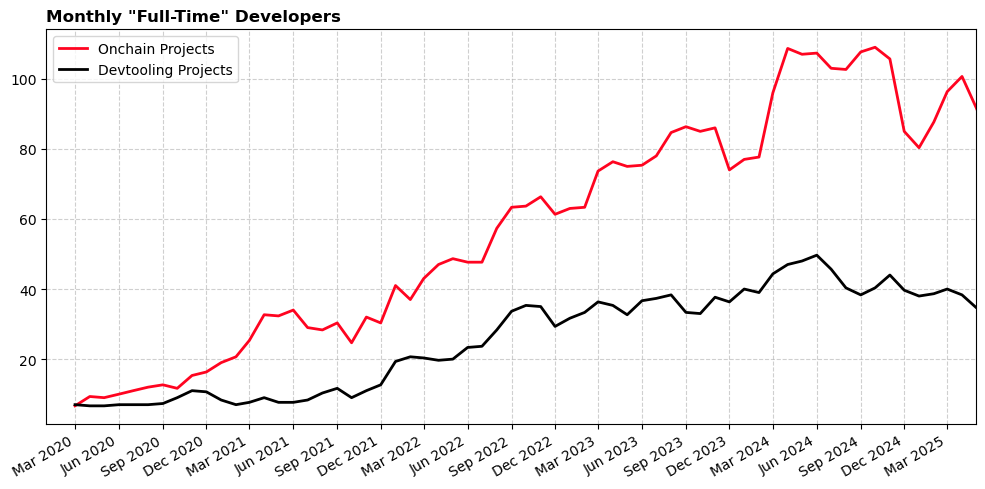

In [49]:
df_downstream_devs['sample_date'] = pd.to_datetime(df_downstream_devs['sample_date'])
df_devtool_metrics['sample_date'] = pd.to_datetime(df_devtool_metrics['sample_date'])

_downstream = (
    df_downstream_devs
    .query(f"metric == 'GITHUB_full_time_developers_monthly' & sample_date < '{GITHUB_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
    .rolling(window=3).mean()
)
_devtool = (
    df_devtool_metrics
    .query(f"metric == 'GITHUB_full_time_developers_monthly' & sample_date < '{GITHUB_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
    .rolling(window=3).mean()
)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(_downstream.index, _downstream.values,
        label='Onchain Projects',
        color='#ff0420', linewidth=2, marker='o', markersize=0)
ax.plot(_devtool.index, _devtool.values,
        label='Devtooling Projects',
        color='black', linewidth=2, marker='s', markersize=0)

ax.set_title('Monthly "Full-Time" Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlim(
    pd.to_datetime("2020-01-01"),
    pd.to_datetime("2025-04-30")
)

ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [50]:
print("Onchain dev growth:", _downstream.loc['2025-04-01'] / _downstream.loc['2023-04-01'])
print("Devtool dev growth:", _devtool.loc['2025-04-01'] / _devtool.loc['2023-04-01'])

Onchain dev growth: 1.3187772925764194
Devtool dev growth: 1.0849056603773586


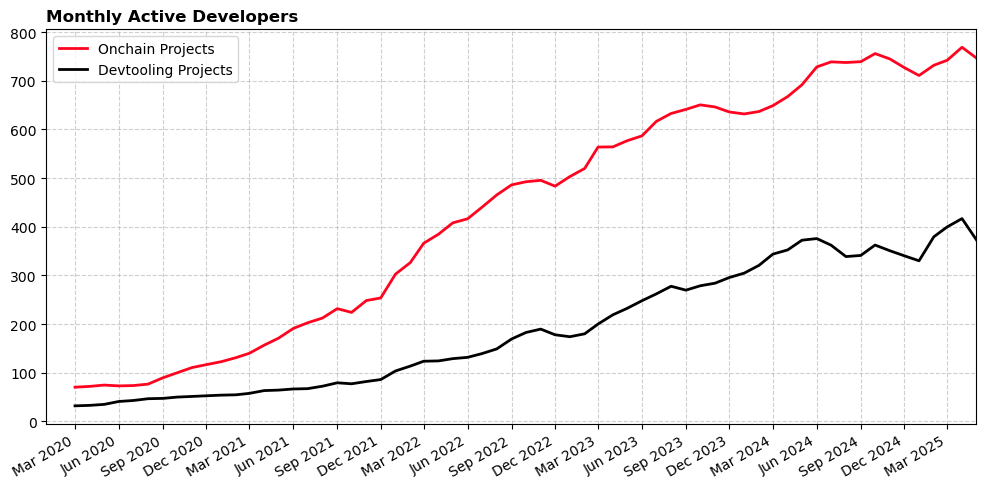

In [51]:
df_downstream_devs['sample_date'] = pd.to_datetime(df_downstream_devs['sample_date'])
df_devtool_metrics['sample_date'] = pd.to_datetime(df_devtool_metrics['sample_date'])

_downstream = (
    df_downstream_devs
    .query(f"metric == 'GITHUB_active_developers_monthly' & sample_date <= '{GITHUB_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
    .rolling(window=3).mean()
)
_devtool = (
    df_devtool_metrics
    .query(f"metric == 'GITHUB_active_developers_monthly' & sample_date <= '{GITHUB_END_DATE}'")
    .groupby('sample_date')['amount']
    .sum()
    .rolling(window=3).mean()
)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(_downstream.index, _downstream.values,
        label='Onchain Projects',
        color='#ff0420', linewidth=2, marker='o', markersize=0)
ax.plot(_devtool.index, _devtool.values,
        label='Devtooling Projects',
        color='black', linewidth=2, marker='s', markersize=0)

ax.set_title('Monthly Active Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')

ax.set_xlim(
    pd.to_datetime("2020-01-01"),
    pd.to_datetime("2025-04-30")
)

ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

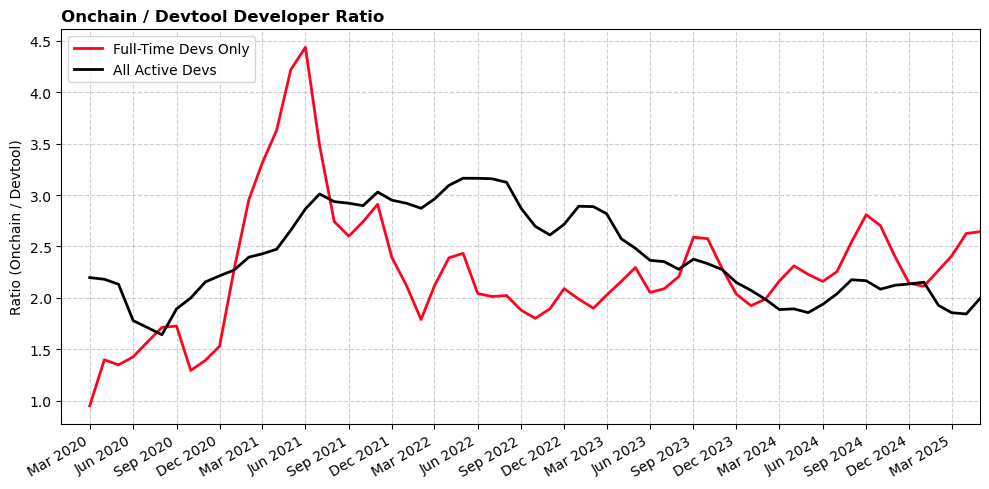

In [52]:
# full-time devs ratio
down_full = df_downstream_devs.loc[
    (df_downstream_devs.metric == 'GITHUB_full_time_developers_monthly')
    & (df_downstream_devs.sample_date < pd.to_datetime(GITHUB_END_DATE))
].groupby('sample_date').amount.sum().rolling(window=3).mean()
dev_full = df_devtool_metrics.loc[
    (df_devtool_metrics.metric == 'GITHUB_full_time_developers_monthly')
    & (df_devtool_metrics.sample_date < pd.to_datetime(GITHUB_END_DATE))
].groupby('sample_date').amount.sum().rolling(window=3).mean()
ratio_full = down_full / dev_full

# active devs ratio
down_active = df_downstream_devs.loc[
    (df_downstream_devs.metric == 'GITHUB_active_developers_monthly')
    & (df_downstream_devs.sample_date <= pd.to_datetime(GITHUB_END_DATE))
].groupby('sample_date').amount.sum().rolling(window=3).mean()
dev_active = df_devtool_metrics.loc[
    (df_devtool_metrics.metric == 'GITHUB_active_developers_monthly')
    & (df_devtool_metrics.sample_date <= pd.to_datetime(GITHUB_END_DATE))
].groupby('sample_date').amount.sum().rolling(window=3).mean()
ratio_active = down_active / dev_active

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ratio_full.index, ratio_full.values, label='Full-Time Devs Only', linewidth=2, color='#ff0420')
ax.plot(ratio_active.index, ratio_active.values, label='All Active Devs', linewidth=2, color='black')

ax.set_title('Onchain / Devtool Developer Ratio', weight='bold', loc='left')
ax.set_ylabel('Ratio (Onchain / Devtool)')
ax.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2025-04-30'))

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')

ax.legend(frameon=True, loc='upper left')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

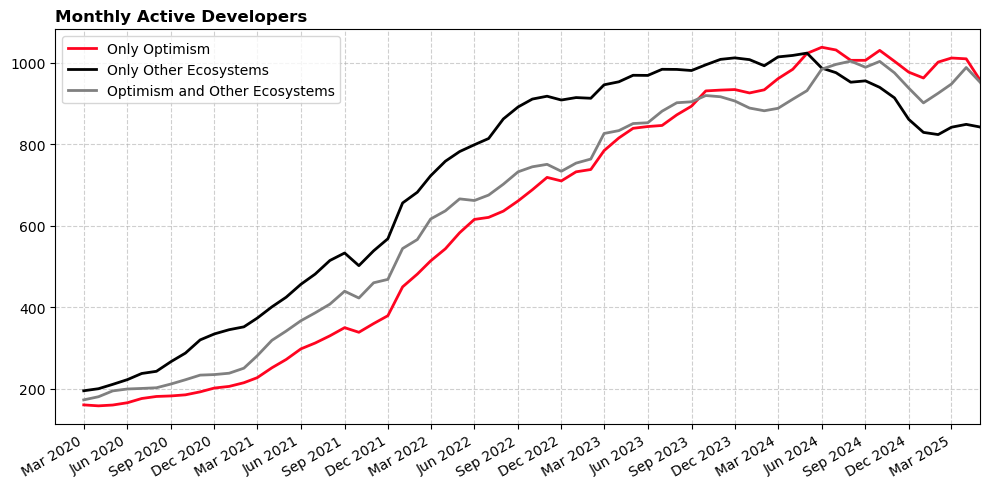

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))

df_dev_cohorts['sample_date'] = pd.to_datetime(df_dev_cohorts['sample_date'])
_df_dev_cohorts_active = df_dev_cohorts.query("metric == 'GITHUB_active_developers_monthly'").pivot(
    index='sample_date',
    columns='cohort',
    values='amount'
).rolling(window=3).mean()

ax.plot(_df_dev_cohorts_active['Only Optimism'], label='Only Optimism',
        color='#ff0420', linewidth=2, marker='o', markersize=0)
ax.plot(_df_dev_cohorts_active['Only Other Ecosystems'], label='Only Other Ecosystems',
        color='black', linewidth=2, marker='s', markersize=0)
ax.plot(_df_dev_cohorts_active['Optimism and Other Ecosystems'], label='Optimism and Other Ecosystems',
        color='gray', linewidth=2, marker='s', markersize=0)

ax.set_title('Monthly Active Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2025-04-30"))
ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

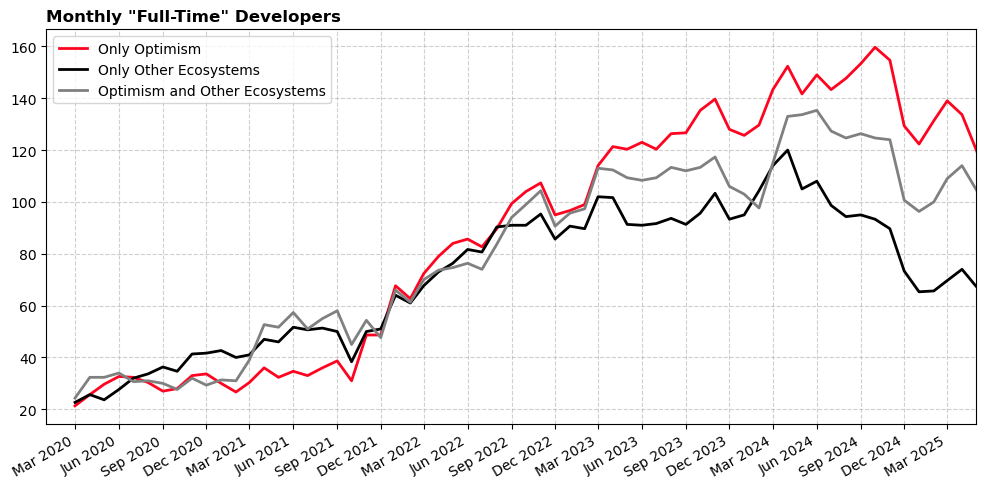

In [54]:
fig, ax = plt.subplots(figsize=(10, 5))

df_dev_cohorts['sample_date'] = pd.to_datetime(df_dev_cohorts['sample_date'])
_df_dev_cohorts_active = df_dev_cohorts.query("metric == 'GITHUB_full_time_developers_monthly'").pivot(
    index='sample_date',
    columns='cohort',
    values='amount'
).rolling(window=3).mean()

ax.plot(_df_dev_cohorts_active['Only Optimism'], label='Only Optimism',
        color='#ff0420', linewidth=2, marker='o', markersize=0)

ax.plot(_df_dev_cohorts_active['Only Other Ecosystems'], label='Only Other Ecosystems',
        color='black', linewidth=2, marker='s', markersize=0)

ax.plot(_df_dev_cohorts_active['Optimism and Other Ecosystems'], label='Optimism and Other Ecosystems',
        color='gray', linewidth=2, marker='s', markersize=0)

ax.set_title('Monthly "Full-Time" Developers', weight='bold', loc='left')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xlim(pd.to_datetime("2020-01-01"), pd.to_datetime("2025-04-30"))
ax.legend(frameon=True, loc='upper left')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate(rotation=30, ha='right')
ax.grid(which='major', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

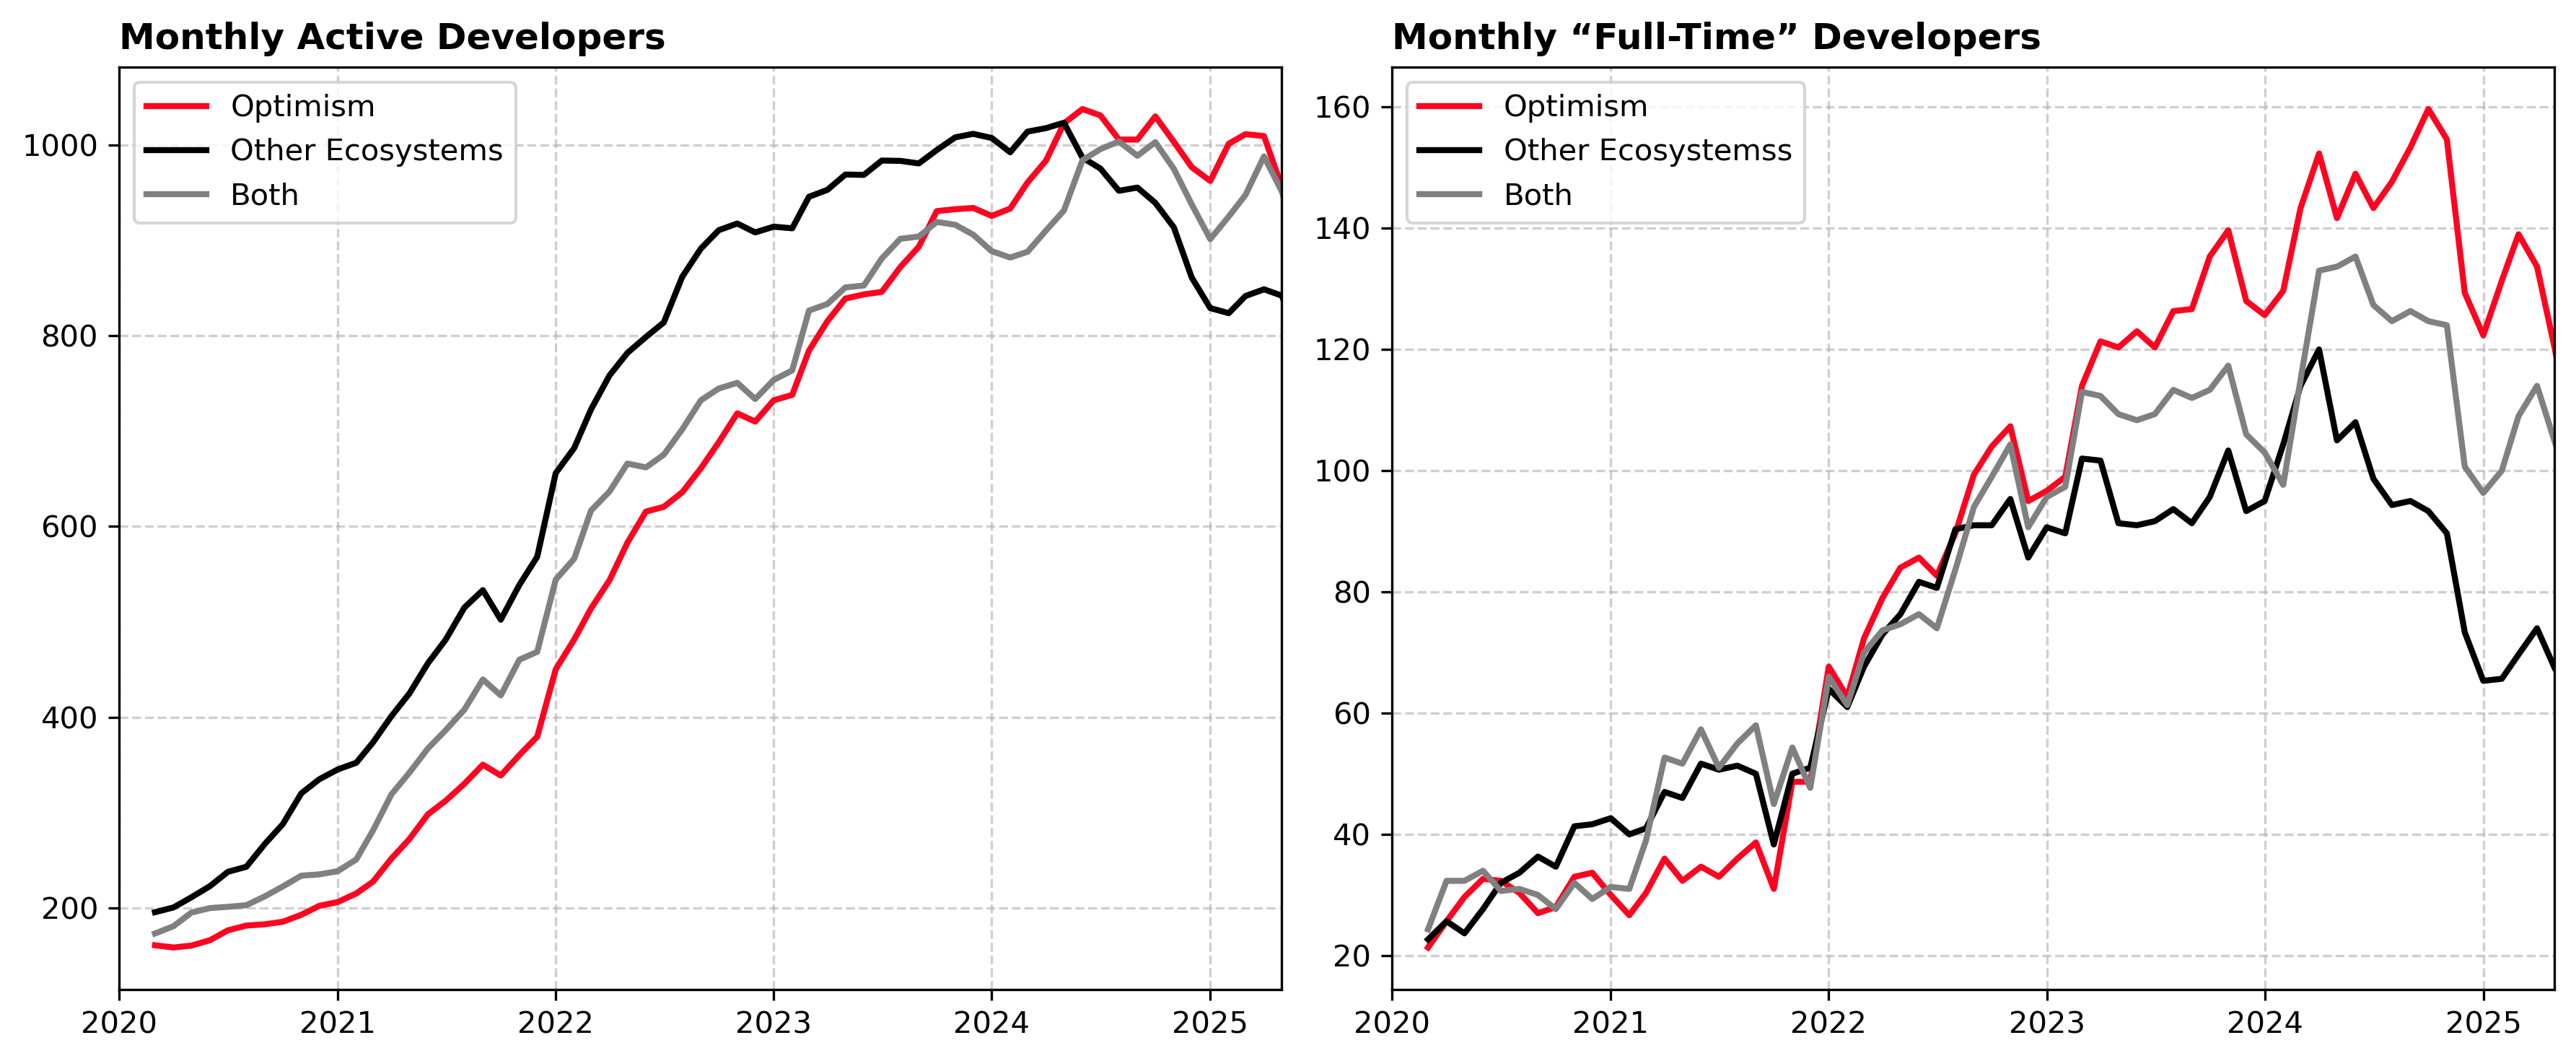

In [55]:
df_dev_cohorts['sample_date'] = pd.to_datetime(df_dev_cohorts['sample_date'])
df_active = (
    df_dev_cohorts
    .query("metric == 'GITHUB_active_developers_monthly'")
    .pivot(index='sample_date', columns='cohort', values='amount')
    .sort_index()
    .rolling(window=3).mean() 
)
df_full_time = (
    df_dev_cohorts
    .query("metric == 'GITHUB_full_time_developers_monthly'")
    .pivot(index='sample_date', columns='cohort', values='amount')
    .sort_index()
    .rolling(window=3).mean() 
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)

c_opt   = '#ff0420'
c_other = 'black'
c_both  = 'gray'

axes[0].plot(df_active['Only Optimism'], label='Optimism', color=c_opt, linewidth=2)
axes[0].plot(df_active['Only Other Ecosystems'], label='Other Ecosystems', color=c_other, linewidth=2)
axes[0].plot(df_active['Optimism and Other Ecosystems'], label='Both',
             color=c_both,  linewidth=2)

axes[0].set_title('Monthly Active Developers', weight='bold', loc='left')
axes[0].legend(frameon=True, loc='upper left')
axes[0].grid(which='major', linestyle='--', alpha=0.6)
axes[0].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2025-04-30'))

axes[1].plot(df_full_time['Only Optimism'], label='Optimism', color=c_opt, linewidth=2)
axes[1].plot(df_full_time['Only Other Ecosystems'], label='Other Ecosystemss', color=c_other, linewidth=2)
axes[1].plot(df_full_time['Optimism and Other Ecosystems'], label='Both',
             color=c_both, linewidth=2)

axes[1].set_title('Monthly “Full-Time” Developers', weight='bold', loc='left')
axes[1].legend(frameon=True, loc='upper left')
axes[1].grid(which='major', linestyle='--', alpha=0.6)
axes[1].set_xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2025-04-30'))
fig.autofmt_xdate(rotation=00, ha='center')

plt.tight_layout()
plt.show()

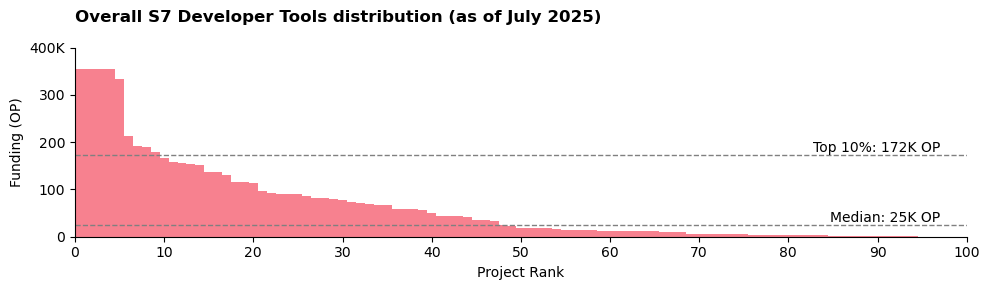

In [61]:
def format_axis(
    ax,
    xmin=None,
    xmax=None,
    xstep=None,
    ymax=None,
    ystep=None,
    xfmt=None,
    yfmt=None,
    xpost=None,
    ypost=None
):
    if xmin is not None or xmax is not None:
        ax.set_xlim(xmin, xmax)
    
    if xstep is not None:
        xticks = np.arange(xmin if xmin is not None else 0, xmax + xstep, xstep)
        ax.set_xticks(xticks)        
        if isinstance(xfmt, str):
            xtick_labels = [format(tick, xfmt) for tick in xticks]
        elif callable(xfmt):
            xtick_labels = [xfmt(tick) for tick in xticks]
        else:
            xtick_labels = [str(tick) for tick in xticks]

        if xpost:
            xtick_labels[-1] += f"{xpost}"
        ax.set_xticklabels(xtick_labels)
    if xpost is not None and not ax.get_xlabel():
        ax.set_xlabel(xpost)

    if ymax is not None:
        ax.set_ylim(0, ymax)
    if ystep is not None:
        yticks = np.arange(0, ymax + ystep, ystep)
        ax.set_yticks(yticks)        
        if isinstance(yfmt, str):
            ytick_labels = [format(tick, yfmt) for tick in yticks]
        elif callable(yfmt):
            ytick_labels = [yfmt(tick) for tick in yticks]
        else:
            ytick_labels = [str(tick) for tick in yticks]
        if ypost:
            ytick_labels[-1] += f"{ypost}"
        ax.set_yticklabels(ytick_labels)
    if ypost is not None and not ax.get_ylabel():
        ax.set_ylabel(ypost)

    return ax

fig, ax = plt.subplots(figsize=(10, 3))
series = df_project_metrics_pivoted[df_project_metrics_pivoted['op_reward'] > 0]['op_reward']
series = series.sort_values(ascending=False) / 1000
series.plot(kind='bar', color='#F00420', alpha=.5, ax=ax, width=1)
xmax = len(series)

format_axis(
    ax,
    xmin=0, 
    xmax=100, 
    xstep=10, 
    ymax=400, 
    ystep=100,
    ypost="K",
    yfmt=".0f"
)

ax.set_xlabel("Project Rank")
ax.tick_params(axis='x', rotation=0)
ax.set_ylabel("Funding (OP)")

med = series.median()
ax.axhline(med, color='grey', linestyle='--', lw=1)
ax.text(s=f"Median: {med:.0f}K OP", x=xmax, y=med, va='bottom', ha='right')    

top10 = series.quantile(.9)
ax.axhline(top10, color='grey', linestyle='--', lw=1)
ax.text(s=f"Top 10%: {top10:.0f}K OP", x=xmax, y=top10, va='bottom', ha='right')    

title = 'Overall S7 Developer Tools distribution (as of July 2025)'
ax.set_title(f"{title}\n", loc='left', weight='bold')
sns.despine()
fig.tight_layout()